In [1]:
import sys, os
sys.path.insert(0, '../..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

os.environ['disable_tqdm'] = 'true'

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
import gc
from tqdm import trange
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.score import statistical_parity
from utils import graph_utils
from utils.snakemake_utils import FileResources
import seaborn as sns
from utils import snakemake_utils
import pickle as pkl
warnings.filterwarnings("ignore")
gc.enable()

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [3]:
! ls /data/sg/ashutiwa/final_crosswalk/airport/airport_one/

airport_adj_crosswalk.npz
airport_adj_fairwalk.npz
airport_adj.npz
airport_crosswalk_deepwalk.npy
airport_crosswalk_node2vec.npy
airport_deepwalk_128_embs.npy
airport_deepwalk.npy
airport_fairwalk_deepwalk.npy
airport_fairwalk_node2vec.npy
airport_gat_None_deepwalk_deepwalk_embs.npy
airport_gat_None_deepwalk_deepwalk.h5
airport_gat_None_deepwalk_r2v_embs.npy
airport_gat_None_deepwalk_r2v.h5
airport_gat_None_node2vec_deepwalk_embs.npy
airport_gat_None_node2vec_deepwalk.h5
airport_gat_None_node2vec_r2v_embs.npy
airport_gat_None_node2vec_r2v.h5
airport_gcn_None_deepwalk_deepwalk_embs.npy
airport_gcn_None_deepwalk_deepwalk.h5
airport_gcn_None_deepwalk_r2v_embs.npy
airport_gcn_None_deepwalk_r2v.h5
airport_gcn_None_node2vec_deepwalk_embs.npy
airport_gcn_None_node2vec_deepwalk.h5
airport_gcn_None_node2vec_r2v_embs.npy
airport_gcn_None_node2vec_r2v.h5
airport_node2vec_128_embs.npy
airport_node2vec.npy
airport_test_adj.npz


In [4]:
y = snakemake_utils.get_dataset("pokec").get_grouped_col()
sp_score, roc_score, gini_score, embs = {}, {}, {}, {}
DATA_ROOT = '/data/sg/ashutiwa/final_crosswalk/pokec/'
DIRS = ['pokec_one/', 'pokec_two/', 'pokec_three/', 'pokec_four/', 'pokec_five/']
DATASET = 'pokec'
model_to_embs = {
    "fairwalk+deepwalk": "_fairwalk_deepwalk.npy",
    "fairwalk+node2vec": "_fairwalk_node2vec.npy",
    "crosswalk+deepwalk": "_crosswalk_deepwalk.npy",
    "crosswalk+node2vec": "_crosswalk_node2vec.npy",
    "GCN+deepwalk+random": "_gcn_None_deepwalk_deepwalk_embs.npy",
    "GCN+deepwalk+r2v": "_gcn_None_deepwalk_r2v_embs.npy",
    "GCN+node2vec+random": "_gcn_None_node2vec_deepwalk_embs.npy",
    "GCN+node2vec+r2v": "_gcn_None_node2vec_r2v_embs.npy",
    "GAT+deepwalk+random": "_gat_None_deepwalk_deepwalk_embs.npy",
    "GAT+deepwalk+r2v": "_gat_None_deepwalk_r2v_embs.npy",
    "GAT+node2vec+random": "_gat_None_node2vec_deepwalk_embs.npy",
    "GAT+node2vec+r2v": "_gat_None_node2vec_r2v_embs.npy",
    "deepwalk": "_deepwalk_128_embs.npy",
    "node2vec": "_node2vec_128_embs.npy"
    
}
M = list(model_to_embs.keys())

TEST_ADJ_FILE='/data/sg/ashutiwa/final_crosswalk/pokec/pokec_one/pokec_test_adj.npz'
NUM_NODES = 1632803
k=5

# distributions of positive and negative edgeswith dot product

In [5]:
def get_roc_score(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)



In [6]:
def plot_dot_(df, title):
#     df = pd.DataFrame({
#         "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
#         "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
#     })
    
#     fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=title)
    df.negative_dot.plot(kind='density', title=title)
#     ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
#     fig.show()

In [7]:
FILE_CACHE = {}
def create_dot_df(A, file=TEST_ADJ_FILE):
    """
    A are node embeddings of shape # nodes \times 128
    """
    EDGE_IDX = snakemake_utils.get_edge_index_from_sparse_path(file)
    if file in FILE_CACHE:
        NEGATIVE_EDGE_IDX, EDGE_IDX = FILE_CACHE[file]
    else:
        NEGATIVE_EDGE_IDX, EDGE_IDX = graph_utils._negative_sampling_sparse(edge_index=EDGE_IDX, n_nodes=NUM_NODES, return_pos_samples=True)
        FILE_CACHE[file] = (NEGATIVE_EDGE_IDX, EDGE_IDX)
    print("selected edge_idx size: {}".format(EDGE_IDX.size(1)))

    positive_dot = np.sum(A[EDGE_IDX[0,:]] * A[EDGE_IDX[1,:]], axis=1)
    negative_dot = np.sum(A[NEGATIVE_EDGE_IDX[0,:]] * A[NEGATIVE_EDGE_IDX[1,:]], axis=1)
    dot = pd.DataFrame()
    dot["positive_dot"] = positive_dot
    dot["negative_dot"] = negative_dot
    
    return dot

# fairwalk+deepwalk

In [8]:
# model = "fairwalk+deepwalk"
# embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
# A = embs[model]
# A.shape

In [9]:
# # plot density
# dot = create_dot_df(A)
# fig, ax = plt.subplots(1,1)

# plot_dot_(dot, title=model + '_dot_density')
# # ax.set_xlim(-750, 750)
# ax.legend(['positive_neighbors', 'negative_neighbors'])
# fig.show()

In [10]:
# # # create edge_list
# batch_size = 2000

# edges = snakemake_utils.return_new_graph(A, k, )
# gini_score[model] = statistical_parity(edges, y, metric='gini')
# sp_score[model] = statistical_parity(edges, y, )

# roc_score[model] = get_roc_score(dot)
# edges.shape, sp_score[model], roc_score[model], gini_score[model]

# fairwalk+node2vec

In [11]:
# model = "fairwalk+node2vec"
# embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
# A = embs[model]
# A.shape


In [12]:
# # plot density
# dot = create_dot_df(A)
# fig, ax = plt.subplots(1,1)

# plot_dot_(dot, title=model + '_dot_density')
# # ax.set_xlim(-750, 750)
# ax.legend(['positive_neighbors', 'negative_neighbors'])
# fig.show()

In [13]:
# # # create edge_list
# batch_size = 2000

# edges = snakemake_utils.return_new_graph(A, k, )
# gini_score[model] = statistical_parity(edges, y, metric='gini')
# sp_score[model] = statistical_parity(edges, y, )

# roc_score[model] = get_roc_score(dot)
# edges.shape, sp_score[model], roc_score[model], gini_score[model]

# crosswalk+deepwalk

In [14]:
# model = "crosswalk+deepwalk"
# embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
# A = embs[model]
# A.shape

In [15]:
# # plot density
# dot = create_dot_df(A)
# fig, ax = plt.subplots(1,1)

# plot_dot_(dot, title=model + '_dot_density')
# # ax.set_xlim(-750, 750)
# ax.legend(['positive_neighbors', 'negative_neighbors'])
# fig.show()

In [16]:
# # # create edge_list
# batch_size = 2000

# edges = snakemake_utils.return_new_graph(A, k, )
# gini_score[model] = statistical_parity(edges, y, metric='gini')
# sp_score[model] = statistical_parity(edges, y, )

# roc_score[model] = get_roc_score(dot)
# edges.shape, sp_score[model], roc_score[model], gini_score[model]

# crosswalk+node2vec

In [17]:
# model = "crosswalk+node2vec"
# embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
# A = embs[model]
# A.shape

In [18]:
# # plot density
# dot = create_dot_df(A)
# fig, ax = plt.subplots(1,1)

# plot_dot_(dot, title=model + '_dot_density')
# # ax.set_xlim(-750, 750)
# ax.legend(['positive_neighbors', 'negative_neighbors'])
# fig.show()

In [19]:
# # # create edge_list
# batch_size = 2000

# edges = snakemake_utils.return_new_graph(A, k, )
# gini_score[model] = statistical_parity(edges, y, metric='gini')
# sp_score[model] = statistical_parity(edges, y, )

# roc_score[model] = get_roc_score(dot)
# edges.shape, sp_score[model], roc_score[model], gini_score[model]

# GCN+deepwalk+random

In [20]:
# model = "GCN+deepwalk+random"
# embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
# A = embs[model]
# A.shape

In [21]:
# # plot density
# dot = create_dot_df(A)
# fig, ax = plt.subplots(1,1)

# plot_dot_(dot, title=model + '_dot_density')
# # ax.set_xlim(-750, 750)
# ax.legend(['positive_neighbors', 'negative_neighbors'])
# fig.show()

In [22]:
# # # create edge_list
# batch_size = 2000

# edges = snakemake_utils.return_new_graph(A, k, )
# gini_score[model] = statistical_parity(edges, y, metric='gini')
# sp_score[model] = statistical_parity(edges, y, )

# roc_score[model] = get_roc_score(dot)
# edges.shape, sp_score[model], roc_score[model], gini_score[model]

# GCN+deepwalk+r2v

In [23]:
# model = "GCN+deepwalk+r2v"
# embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
# A = embs[model]
# A.shape


In [24]:
# # plot density
# dot = create_dot_df(A)
# fig, ax = plt.subplots(1,1)

# plot_dot_(dot, title=model + '_dot_density')
# # ax.set_xlim(-750, 750)
# ax.legend(['positive_neighbors', 'negative_neighbors'])
# fig.show()

In [25]:
# # # create edge_list
# batch_size = 2000

# edges = snakemake_utils.return_new_graph(A, k, )
# gini_score[model] = statistical_parity(edges, y, metric='gini')
# sp_score[model] = statistical_parity(edges, y, )

# roc_score[model] = get_roc_score(dot)
# edges.shape, sp_score[model], roc_score[model], gini_score[model]

# GCN+node2vec+random

In [26]:
# model = "GCN+node2vec+random"
# embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
# A = embs[model]
# A.shape

In [27]:
# # plot density
# dot = create_dot_df(A)
# fig, ax = plt.subplots(1,1)

# plot_dot_(dot, title=model + '_dot_density')
# # ax.set_xlim(-750, 750)
# ax.legend(['positive_neighbors', 'negative_neighbors'])
# fig.show()

In [28]:
# # # create edge_list
# batch_size = 2000

# edges = snakemake_utils.return_new_graph(A, k, )
# gini_score[model] = statistical_parity(edges, y, metric='gini')
# sp_score[model] = statistical_parity(edges, y, )

# roc_score[model] = get_roc_score(dot)
# edges.shape, sp_score[model], roc_score[model], gini_score[model]

# GCN+node2vec+r2v

In [29]:
# model = "GCN+node2vec+r2v"
# embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
# A = embs[model]
# A.shape

In [30]:
# # plot density
# dot = create_dot_df(A)
# fig, ax = plt.subplots(1,1)

# plot_dot_(dot, title=model + '_dot_density')
# # ax.set_xlim(-750, 750)
# ax.legend(['positive_neighbors', 'negative_neighbors'])
# fig.show()

In [31]:
# # # create edge_list
# batch_size = 2000

# edges = snakemake_utils.return_new_graph(A, k, )
# gini_score[model] = statistical_parity(edges, y, metric='gini')
# sp_score[model] = statistical_parity(edges, y, )

# roc_score[model] = get_roc_score(dot)
# edges.shape, sp_score[model], roc_score[model], gini_score[model]

# GAT+deepwalk+random

In [32]:
# model = "GAT+deepwalk+random"
# embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
# A = embs[model]
# A.shape

In [33]:
# # plot density
# dot = create_dot_df(A)
# fig, ax = plt.subplots(1,1)

# plot_dot_(dot, title=model + '_dot_density')
# # ax.set_xlim(-750, 750)
# ax.legend(['positive_neighbors', 'negative_neighbors'])
# fig.show()

In [34]:
# # # create edge_list
# batch_size = 2000

# edges = snakemake_utils.return_new_graph(A, k, )
# gini_score[model] = statistical_parity(edges, y, metric='gini')
# sp_score[model] = statistical_parity(edges, y, )

# roc_score[model] = get_roc_score(dot)
# edges.shape, sp_score[model], roc_score[model], gini_score[model]

# GAT+deepwalk+r2v

In [35]:
# model = "GAT+deepwalk+r2v"
# embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
# A = embs[model]
# A.shape

In [36]:
# # plot density
# dot = create_dot_df(A)
# fig, ax = plt.subplots(1,1)

# plot_dot_(dot, title=model + '_dot_density')
# # ax.set_xlim(-750, 750)
# ax.legend(['positive_neighbors', 'negative_neighbors'])
# fig.show()

In [37]:
# # # create edge_list
# batch_size = 2000

# edges = snakemake_utils.return_new_graph(A, k, )
# gini_score[model] = statistical_parity(edges, y, metric='gini')
# sp_score[model] = statistical_parity(edges, y, )

# roc_score[model] = get_roc_score(dot)
# edges.shape, sp_score[model], roc_score[model], gini_score[model]

# GAT+node2vec+random

In [38]:
# model = "GAT+node2vec+random"
# embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
# A = embs[model]
# A.shape

In [39]:
# # plot density
# dot = create_dot_df(A)
# fig, ax = plt.subplots(1,1)

# plot_dot_(dot, title=model + '_dot_density')
# # ax.set_xlim(-750, 750)
# ax.legend(['positive_neighbors', 'negative_neighbors'])
# fig.show()

In [40]:
# # # create edge_list
# batch_size = 2000

# edges = snakemake_utils.return_new_graph(A, k, )
# gini_score[model] = statistical_parity(edges, y, metric='gini')
# sp_score[model] = statistical_parity(edges, y, )

# roc_score[model] = get_roc_score(dot)
# edges.shape, sp_score[model], roc_score[model], gini_score[model]

# GAT+node2vec+r2v

In [41]:
# model = "GAT+node2vec+r2v"
# embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
# A = embs[model]
# A.shape

In [42]:
# # plot density
# dot = create_dot_df(A)
# fig, ax = plt.subplots(1,1)

# plot_dot_(dot, title=model + '_dot_density')
# # ax.set_xlim(-750, 750)
# ax.legend(['positive_neighbors', 'negative_neighbors'])
# fig.show()

In [43]:
# # # create edge_list
# batch_size = 2000

# edges = snakemake_utils.return_new_graph(A, k, )
# gini_score[model] = statistical_parity(edges, y, metric='gini')
# sp_score[model] = statistical_parity(edges, y, )

# roc_score[model] = get_roc_score(dot)
# edges.shape, sp_score[model], roc_score[model], gini_score[model]

# plot statistical parity scores

# gini sp scores

In [44]:

# for i, j in gini_score.items(): print(i, j)
# sns.set(rc = {'figure.figsize':(15,8)})
# ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
# ax.set_ylim(min(gini_score.values()) * .9 , max(gini_score.values()) * 1.1)
# ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
# ax.set_title("gini statistical parity scores")

# sp scores

In [45]:

# for i, j in sp_score.items(): print(i, j)
# sns.set(rc = {'figure.figsize':(15,8)})
# ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
# ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
# ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
# ax.set_title("statistical parity scores")

# roc auc scores

In [46]:

# for i, j in roc_score.items(): print(i, j)
# sns.set(rc = {'figure.figsize':(15,8)})
# ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
# ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
# ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
# ax.set_title("roc scores")

In [47]:

# N = 20

# sp_scores, gini_scores = np.zeros((N, len(M))), np.zeros((N, len(M)))
# for k in range(N):
#     for idx, m in enumerate(M):
#         if k == 0: continue
#         batch_size =  2000
#         A = embs[m]
#         edges = snakemake_utils.return_new_graph(A, k, )
        
    
#         gini_scores[k, idx] = statistical_parity(edges, y, metric='gini')
#         sp_scores[k, idx] = statistical_parity(edges, y, )


In [48]:
# for i in range(len(M)):
#     plt.plot(gini_scores[:, i], label=M[i])
# plt.legend(loc="upper right")
# plt.title("gini scores vs # nn")

In [49]:
# for i in range(len(M)):
#     plt.plot(sp_scores[:, i], label=M[i])
# plt.legend(loc="upper right")

# plt.title("sp scores vs # nn")

# combine all different runs

In [50]:

def roc_scores(model_name):
    scores = np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        file = DATA_ROOT + d + DATASET + '_test_adj.npz'
        dot = create_dot_df(A, file)
        scores[idx] = get_roc_score(dot)
    return scores


def statisticalp_scores(model_name, K=5):
    scores, scores_gini = np.zeros(len(DIRS)), np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        edges = snakemake_utils.return_new_graph(A, K)
        scores_gini[idx] = statistical_parity(edges, y, metric='gini')
        
        scores[idx] = statistical_parity(edges, y, )
    return scores, scores_gini

selected edge_idx size: 17917717
selected edge_idx size: 17919216
selected edge_idx size: 17916741
selected edge_idx size: 17917951
selected edge_idx size: 17918097
selected edge_idx size: 17917717
selected edge_idx size: 17919216
selected edge_idx size: 17916741
selected edge_idx size: 17917951
selected edge_idx size: 17918097
selected edge_idx size: 17917717
selected edge_idx size: 17919216
selected edge_idx size: 17916741
selected edge_idx size: 17917951
selected edge_idx size: 17918097
selected edge_idx size: 17917717
selected edge_idx size: 17919216
selected edge_idx size: 17916741
selected edge_idx size: 17917951
selected edge_idx size: 17918097
selected edge_idx size: 17917717
selected edge_idx size: 17919216
selected edge_idx size: 17916741
selected edge_idx size: 17917951
selected edge_idx size: 17918097
selected edge_idx size: 17917717
selected edge_idx size: 17919216
selected edge_idx size: 17916741
selected edge_idx size: 17917951
selected edge_idx size: 17918097
selected e

Text(0.5, 1.0, 'roc scores')

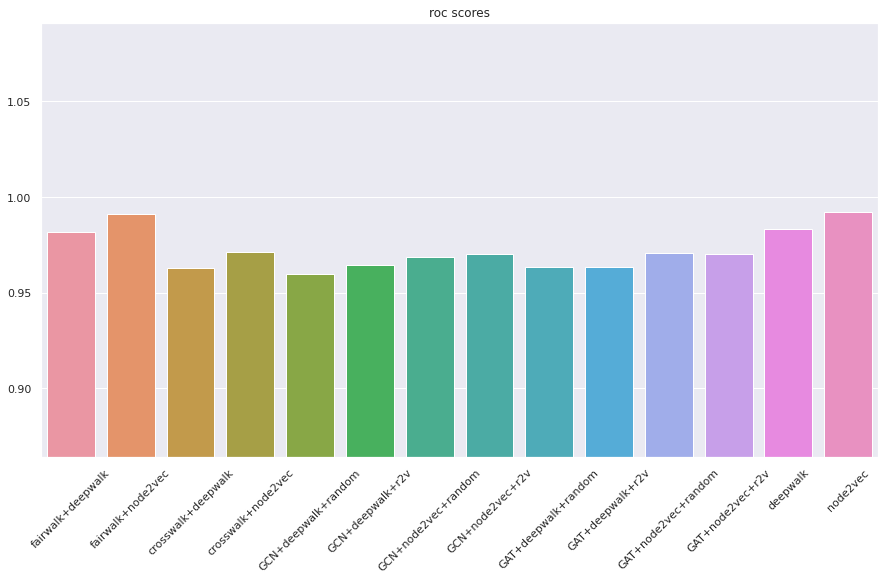

In [51]:

roc_score = {m: np.mean(roc_scores(m)) for m in model_to_embs}

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 816/816 [00:08<00:00, 97.09it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 816/816 [00:09<00:00, 86.29it/s]


fairwalk+deepwalk 9.396449164592177e-07
fairwalk+node2vec 9.86979785018412e-07
crosswalk+deepwalk 9.334447338525636e-07
crosswalk+node2vec 9.749408015532977e-07
GCN+deepwalk+random 7.671799637929431e-07
GCN+deepwalk+r2v 7.678600433306331e-07
GCN+node2vec+random 8.040647423891861e-07
GCN+node2vec+r2v 8.02886353980177e-07
GAT+deepwalk+random 7.682661162281262e-07
GAT+deepwalk+r2v 7.677394656760628e-07
GAT+node2vec+random 8.044280589715197e-07
GAT+node2vec+r2v 8.050831290130308e-07
deepwalk 9.439851499161663e-07
node2vec 1.0205721126012086e-06


Text(0.5, 1.0, 'statistical parity scores')

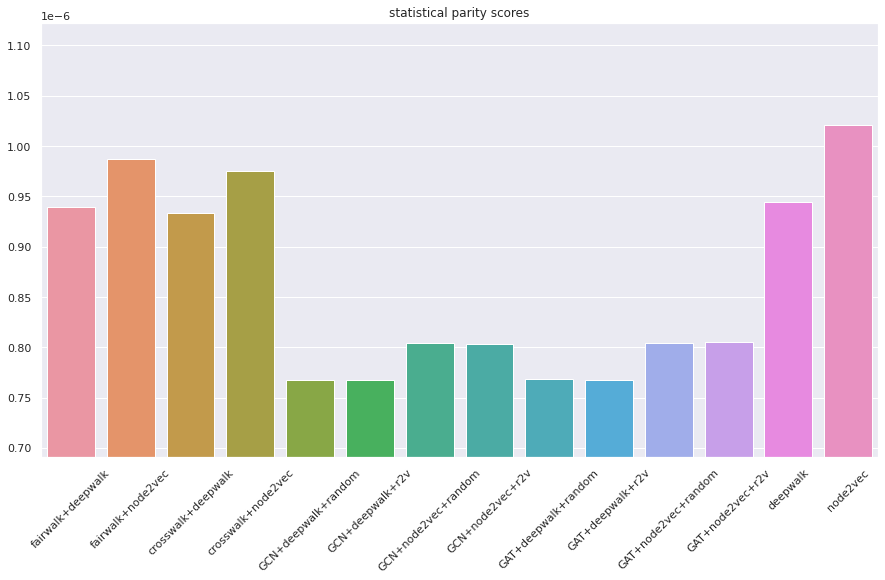

In [52]:

temp = {m: statisticalp_scores(m) for m in model_to_embs}

sp_score = {m: np.mean(v[0]) for m,v in temp.items()}
for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

fairwalk+deepwalk 0.08451818846750281
fairwalk+node2vec 0.09567440064499835
crosswalk+deepwalk 0.088622073463631
crosswalk+node2vec 0.09937933442080846
GCN+deepwalk+random 0.07702268240556916
GCN+deepwalk+r2v 0.07725340674113503
GCN+node2vec+random 0.07895043559038487
GCN+node2vec+r2v 0.07873493418104163
GAT+deepwalk+random 0.07690359760134449
GAT+deepwalk+r2v 0.07710812125246938
GAT+node2vec+random 0.07876128896185909
GAT+node2vec+r2v 0.0788284765399616
deepwalk 0.08584283937699871
node2vec 0.09972975227595313


Text(0.5, 1.0, 'gini statistical parity scores')

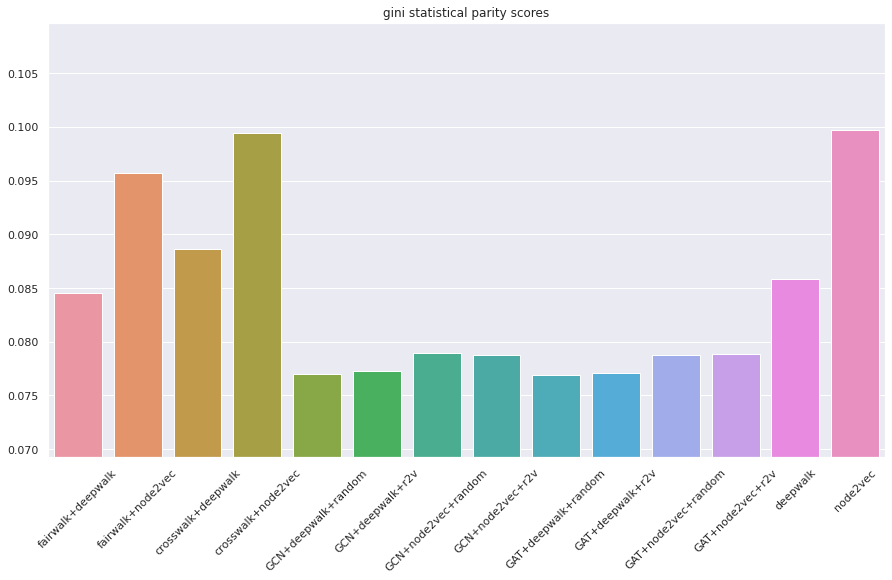

In [53]:
gini_score = {m: np.mean(v[1]) for m,v in temp.items()}
for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9, max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

In [54]:

# roc_score, sp_score, gini_score= {}, {}, {}
roc_score = {m: roc_scores(m) for m in model_to_embs}
temp = {m: statisticalp_scores(m) for m in model_to_embs}
sp_score = {m: v[0] for m,v in temp.items()}
gini_score = {m: v[1] for m,v in temp.items()}
pkl.dump(roc_score, open(DATA_ROOT + "roc_score.pkl", 'wb'))

pkl.dump(sp_score, open(DATA_ROOT + "sp_score.pkl", 'wb'))

pkl.dump(gini_score, open(DATA_ROOT + "gini_score.pkl", 'wb'))

selected edge_idx size: 17917717
selected edge_idx size: 17919216
selected edge_idx size: 17916741
selected edge_idx size: 17917951
selected edge_idx size: 17918097
selected edge_idx size: 17917717
selected edge_idx size: 17919216
selected edge_idx size: 17916741
selected edge_idx size: 17917951
selected edge_idx size: 17918097
selected edge_idx size: 17917717
selected edge_idx size: 17919216
selected edge_idx size: 17916741
selected edge_idx size: 17917951
selected edge_idx size: 17918097
selected edge_idx size: 17917717
selected edge_idx size: 17919216
selected edge_idx size: 17916741
selected edge_idx size: 17917951
selected edge_idx size: 17918097
selected edge_idx size: 17917717
selected edge_idx size: 17919216
selected edge_idx size: 17916741
selected edge_idx size: 17917951
selected edge_idx size: 17918097
selected edge_idx size: 17917717
selected edge_idx size: 17919216
selected edge_idx size: 17916741
selected edge_idx size: 17917951
selected edge_idx size: 17918097
selected e

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 816/816 [00:08<00:00, 98.21it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 816/816 [00:09<00:00, 83.60it/s]
